# Calculating response strength

In this notebook, I implement some different versions of response strength (peak kde, 500ms firing rate vs baseline).

We want to use this to flexibly compare response strength between different categories of stimuli (e.g. familiar vs unfamiliar). We probably will want to do such comparisons elsewhere as well.

* Response strength function definitions

* Helper functions for splitting data across certain filters

* Splitting stimuli by renditions (x3 for songs, x3 for distance calls)

We will response strength measures to (1) evaluate whether there is a significant auditory response versus silence and (2) compare response strength in trials under two or more conditions. (1) requires an evaluation of the response strength against baseline, while (2) only requires an absolute measure of response strength during the stimulus, regardless of baseline. So I will try to keep the "stim response" and "baseline response" levels separate and only incorporate the baseline when necessary.

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

from soundsig.sound import spectrogram, plot_spectrogram

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

import groups
from analysis import (
    fit_kde,
    get_stimulus_timeseries
)
from load_data import (
    load_spike_data,
    load_stim_data,
    load_ephys_stimulus,
    load_unit_waveforms
)
from plotting import plot_raster
from stats import jackknife
from utils import Colors, clean_spike_times, generate_synthetic_poisson_spike_times

%load_ext autoreload
%autoreload 2

In [2]:
ephys_data = load_spike_data()

### As I did in the Load Ephys Data Example notebook, I'll pick the highest SNR units as examples

In [3]:
stim_df = ephys_data.query("""
    stimulus_file == "So_Stim_3_PeLBlaGre_526554_0.wav"
""")
row1 = stim_df.sort_values(["n_trials", "snr"], ascending=False).iloc[0]
row2 = stim_df.sort_values(["n_trials", "snr"], ascending=False).iloc[1]

In [4]:
unit1_df = ephys_data.query("""
    unit_id == "{}"
""".format(row1["unit_id"]))

unit2_df = ephys_data.query("""
    unit_id == "{}"
""".format(row2["unit_id"]))

## I. Definition 1: $RS_{fr500} = FR(\text{500ms before stim onset}) - FR(\text{500ms after stim onset})$

The first function is a plotter of KDE during the 500ms before and after stim onset to use as a visual validation
of the result of calculating mean firing rate

In [5]:
def plot_kde(df, plot_errors=False, **kwargs):
    """Plot the kde of the selected unit, highlighting the 500ms before and after stim onset"""
    spike_times = np.concatenate(list(filter(lambda x: len(x), df["spike_times"])))
    
    end_time = np.min(df["stim_duration"]) + 0.5
    t_arr, result, (ci_low, ci_high) = fit_kde(spike_times, (-0.5, end_time), return_rate=True, estimate_std_error=plot_errors)
    
    if "label" not in kwargs:
        kwargs["label"] = "KDE"
        
    plotted_line = plt.plot(t_arr, result, **kwargs)
    if ci_low is not None:
        plt.plot(t_arr, ci_low, alpha=0.2, color="Black", linestyle=":")
        plt.plot(t_arr, ci_high, alpha=0.2, color="Black", linestyle=":")
    
    fill_lim = plt.ylim()
    plt.ylabel("Firing Rate (Hz)")
    plt.xlabel("t (seconds)")
    return plotted_line

In [6]:
from analysis import ResponseStrength as RS

def plot_response_strength_1(unit_df):
    mean0, se0 = RS.rate(np.concatenate(unit_df["spike_times"]), time_window=(-0.5, 0.0))
    mean1, se1 = RS.rate(np.concatenate(unit_df["spike_times"]), time_window=(0, 0.5))
    plt.bar(-0.25, mean0, 0.5, yerr=2 * se0, color="Grey", alpha=0.5, capsize=10, label="Baseline")
    plt.bar(0.25, mean1, 0.5, yerr=2 * se1, color="LightBlue", alpha=0.5, capsize=10, label="RS")

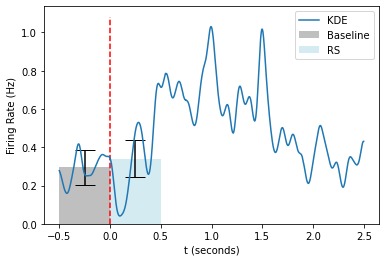

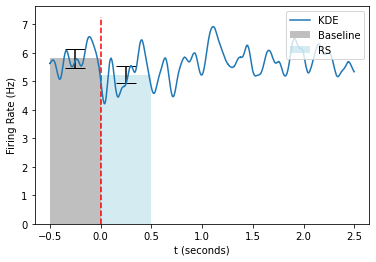

In [7]:
plot_response_strength_1(unit1_df)
plot_kde(unit1_df)
plt.vlines(0, *plt.ylim(), linestyle="--", color="Red")
plt.legend(loc="upper right")
plt.show()

plot_response_strength_1(unit2_df)
plot_kde(unit2_df)
plt.vlines(0, *plt.ylim(), linestyle="--", color="Red")
plt.legend(loc="upper right")
plt.show()

## Definition 2. $RS_{peakKDE} = max(KDE_{\text{during stim}}) - max(KDE_{\text{poisson}})$

This measure of response strength isn't as reliant on there being spikes exactly at stimulus onset. By taking the max KDE, if there is a single moment of strong response during a stimulus, it will be detected.

Now, because we are taking the max of a random signal, we have to correct for the fact that a longer signal is just going to have a larger mean (on average). See demonstrations below. The question is, how do we correct for that?

There are two baselines that we can consider. One is the baseline of silence vs stim. This can tell is if the unit is auditory but it is probably unncessary if we are just comparing response strenghts across conditions. The second baseline is to what we would expect our estimation of the max value would be if we had just a random signal. This does change depending on duration of the stimulus. Thus, we should compute and subtract off a baseline for each unit that is what we woudl have expected the peak kde to be of a signal of the same length with the given number of spikes. However, this is turning out to be quite complicated so I am thinking so in this notebok I'll document how to compute some of these baselines but not use them at this time until its clear I need to

In [8]:
from analysis import ResponseStrength as RS

def plot_response_strength_2(unit_df):
    # Use stim duration equal to the shortest stim
    stim_duration = np.min(unit_df["stim_duration"])
    spike_times = np.concatenate(unit_df["spike_times"])
    
    # Compute baseline from baseline firing rate
    baseline_rate, _ = RS.rate(spike_times, time_window=(-0.5, 0.0))
    synthetic_spike_times = generate_synthetic_poisson_spike_times(
        baseline_rate, stim_duration, len(spike_times))
    
    mean0, se0 = RS.max_response(
        synthetic_spike_times,
        stim_duration=stim_duration,
        compute_std_error=True
    )
    
    # Compute response strength
    mean1, se1 = RS.max_response(
        spike_times, 
        stim_duration=stim_duration,
        compute_std_error=True
    )

    plt.hlines(mean0, -0.5, 0, color="Black", label="Baseline KDE")
    plt.fill_between([-0.5, 0], mean0 - 2 * se0, mean0 + 2 * se0, color="Grey", alpha=0.2)
    plt.hlines(mean1, 0, stim_duration, color="LightBlue", label="Max KDE")
    plt.fill_between([0, stim_duration], mean1 - 2 * se1, mean1 + 2 * se1, color="LightBlue", alpha=0.2)


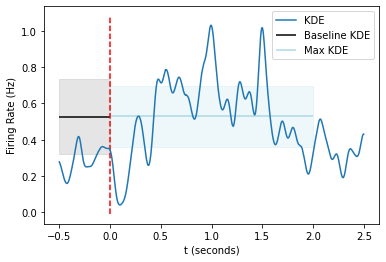

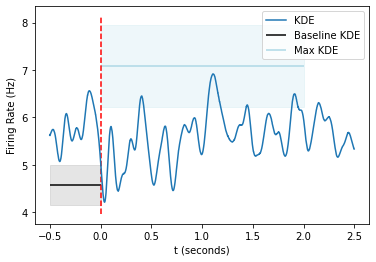

In [9]:
plot_response_strength_2(unit1_df)
plot_kde(unit1_df)
plt.vlines(0, *plt.ylim(), linestyle="--", color="Red")
plt.legend(loc="upper right")
plt.show()

plot_response_strength_2(unit2_df)
plot_kde(unit2_df)
plt.vlines(0, *plt.ylim(), linestyle="--", color="Red")
plt.legend(loc="upper right")
plt.show()

### More explanation of the baseline KDE

Here I demonstrate that (on average) the max of a short window (-0.5s to 0.0s) will be less than that of a longer window (e.g. 0.0 to 6.0 for songs), by using synthetic spike trains.

This is why this metric must be compared against a baseline - the max response of a 2 second stimulus (such as our ripples) would be expected to be lower than the max response to a 6 second stimulus (such as our songs), even if the signal is completely random.

Maybe there is an analytical solution for the max kde as a function of duration? This would make things a lot better

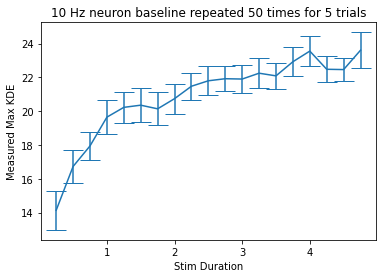

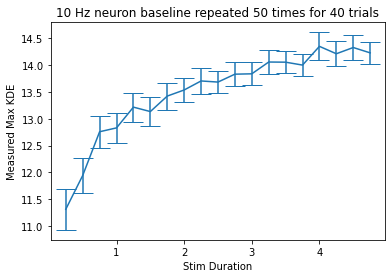

In [10]:
durations = np.arange(1, 20) / 4
max_kdes = []
max_kde_ses = []

n = 50
trials = 5

for duration in durations:
    _maxes = []
    for _ in range(n):
        spikes = generate_synthetic_poisson_spike_times(10.0, duration, trials)
        t, kde, _ = fit_kde(spikes, (0, duration), return_rate=True)
        mean1, se1 = RS.max_response(spikes, stim_duration=duration)
        _maxes.append(mean1)
    
    max_kdes.append(np.mean(_maxes))
    max_kde_ses.append(np.std(_maxes) / np.sqrt(len(_maxes)))

max_kdes = np.array(max_kdes)
max_kde_ses = np.array(max_kde_ses)
    
plt.errorbar(durations, max_kdes, yerr=2 * max_kde_ses, capsize=10)
plt.xlabel("Stim Duration")
plt.ylabel("Measured Max KDE")
plt.title("10 Hz neuron baseline repeated {} times for {} trials".format(n, trials))
plt.show()


durations = np.arange(1, 20) / 4
max_kdes = []
max_kde_ses = []

n = 50
trials = 40

for duration in durations:
    _maxes = []
    for _ in range(n):
        spikes = generate_synthetic_poisson_spike_times(10.0, duration, trials)
        t, kde, _ = fit_kde(spikes, (0, duration), return_rate=True)
        mean1, se1 = RS.max_response(spikes, stim_duration=duration)
        _maxes.append(mean1)
    
    max_kdes.append(np.mean(_maxes))
    max_kde_ses.append(np.std(_maxes) / np.sqrt(len(_maxes)))

max_kdes = np.array(max_kdes)
max_kde_ses = np.array(max_kde_ses)
    
plt.errorbar(durations, max_kdes, yerr=2 * max_kde_ses, capsize=10)
plt.xlabel("Stim Duration")
plt.ylabel("Measured Max KDE")
plt.title("10 Hz neuron baseline repeated {} times for {} trials".format(n, trials))
plt.show()

### This is how you would generate a baseline from poisson data

In [11]:
def demonstrate_baseline(unit_df):
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_axes([0, 0, 0.8, 0.8])
    
    t_arr, kde, _ = fit_kde(
       unit_df.iloc[0]["spike_times"],
        (0, unit_df.iloc[0]["stim_duration"])
    )
    ax.plot(t_arr, kde)
    
    ax2 = fig.add_axes([1, 0, 0.8, 0.8])

    baseline_rate, _ = RS.rate(
        unit_df.iloc[0]["spike_times"],
        (0, unit_df.iloc[0]["stim_duration"]),
    )
    spikes = generate_synthetic_poisson_spike_times(
        baseline_rate, unit_df.iloc[0]["stim_duration"], unit_df.iloc[0]["n_trials"]
    )
    t_arr, kde, _ = fit_kde(
       spikes,
        (0, unit_df.iloc[0]["stim_duration"])
    )
    ax2.plot(t_arr, kde)
    
    ylim_max = max(ax.get_ylim()[1], ax2.get_ylim()[1])

    plot_raster(
        unit_df.iloc[0]["spike_times"],
        yrange=(0, -ylim_max),
        ax=ax,
        color="Black"
    )

    plot_raster(
        spikes,
        yrange=(0, -ylim_max),
        ax=ax2,
        color="Black"
    )
    ax.set_ylim(-ylim_max, ylim_max)
    ax2.set_ylim(-ylim_max, ylim_max)
    
    ax.set_xlim(-0.5, 3.5)
    ax2.set_xlim(-0.5, 3.5)
    
    ax.set_title("Actual Response to Stim")
    ax.set_xlabel("time (seconds)")
    ax.set_ylabel("FR (Hz)")
    
    ax2.set_title("Simulated Poisson Data (using firing rate)")
    ax2.set_xlabel("time (seconds)")
    ax2.set_ylabel("FR (Hz)")

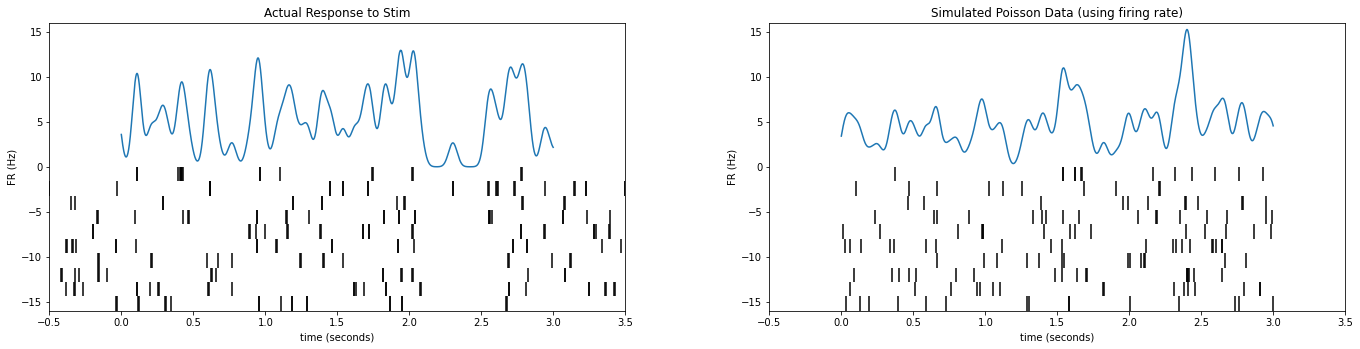

In [12]:
demonstrate_baseline(unit2_df)
plt.show()

### Max Response conclusion

This normalization method would essentially subtract off the entire response to zero (for an entirely rate code, even firing rate throughout). So I don't think this is correct to do either.

(1) Normalize to silence: used to determine if response is auditory

(2) Normalize to duration: used for comparison between groups - maybe better to simply choose the min stim duration as the comparison duration.

## III. Application of these measures to determine stimulus selectivity

For the two example units, lets evaluate the response strength measures for every stimulus file.

In [13]:
def _draw_labels(*tiers, start_y=-0.1, step_y=-0.1):
    """Draw hierarchical labels"""
    ax = plt.gca()
    
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([])
    
    current_y = start_y
    for i, tier in enumerate(tiers):
        for name, (xmin, xmax) in tier:
            # Make a Transform that lets us plot in the y-direction using
            # axes coordinates (i.e. 0,0 bottom left, 1,1 top right)
            # and plot in data coordinates in the x-direction
            custom_transform = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
            if xmin == xmax:
                # Try to draw a tiny sliver
                xmin = xmin - 0.25
                xmax = xmax + 0.25

            ax.add_patch(
                patches.Rectangle(
                    (xmin, current_y),
                    xmax - xmin,
                    np.abs(step_y) / 10, 
                    transform=custom_transform,
                    color="Black",
                    clip_on=False
                )
            )
            ax.text(
                np.mean([xmin, xmax]), 
                current_y,
                name,
                fontsize=12,
                verticalalignment="top" if step_y < 0 else "bottom",
                horizontalalignment="center",
                transform=custom_transform
            )
        current_y += step_y
        

from itertools import product

def plot_all_stim_responses(unit_df, mode="rate"):
    """
    mode can be "rate" to use RS.rate (definition 1) or "max_response" to use RS.max_response (definition 2)
    
    max_response is calculated in the first 2 seconds only (duration of the shortest stim, ripples)
    """
    unit_df = unit_df.sort_values(
        ["relation", "call_type", "reward_class", "self", "stimulus_file"],
        ascending=[False, False, False, False, False]
    )
    
    if mode == "max_response":
        min_stim_duration = np.min(unit_df["stim_duration"])
        
    # Break it up into groups so I can label better on the x-axis
    next_bar_x_pos = 0.5
    # Record the label name and the x-range for the spanning label
    group_level_labels = []
    call_type_level_labels = []
    self_labels = []
    
    for relation, relation_df in unit_df.groupby("relation"):
        group_level_labels.append((relation, (next_bar_x_pos, next_bar_x_pos + len(relation_df) - 1)))
        
        for call_type, call_type_df in relation_df.groupby("call_type"):
            call_type_level_labels.append((call_type, (next_bar_x_pos, next_bar_x_pos + len(call_type_df) - 1)))
            
            for i in range(len(call_type_df)):
                row = call_type_df.iloc[i]
                
                if row["self"]:
                    self_labels.append(("self", (next_bar_x_pos, next_bar_x_pos)))
                
                if mode == "rate":
                    response, se = RS.rate(row["spike_times"], time_window=(0, row["stim_duration"]))
                elif mode == "max_response":
                    response, se = RS.max_response(row["spike_times"], min_stim_duration, compute_std_error=True)

                plt.bar(
                    next_bar_x_pos, 
                    response, 
                    yerr=2 * se, 
                    color=getattr(Colors, row["call_type"])
                )
                
                next_bar_x_pos += 1
    
    _draw_labels(call_type_level_labels, group_level_labels, self_labels)

    plt.ylabel("Response Strength")
    

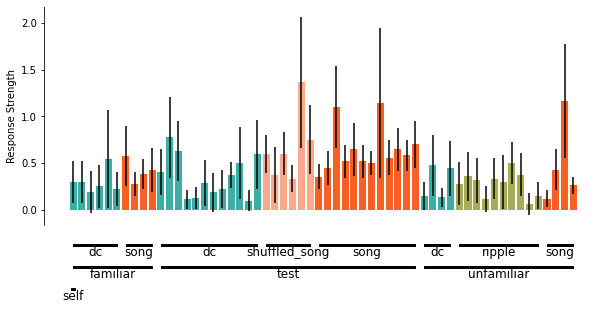

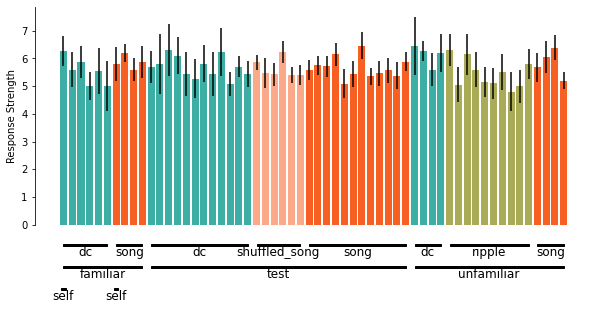

In [14]:
fig = plt.figure(figsize=(10, 4))
plot_all_stim_responses(unit1_df, mode="rate")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(10, 4))
plot_all_stim_responses(unit2_df, mode="rate")
plt.show()
plt.close(fig)

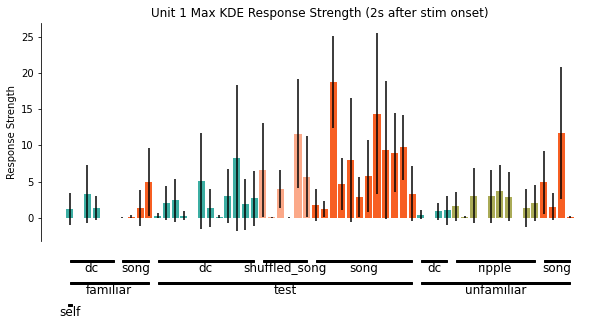

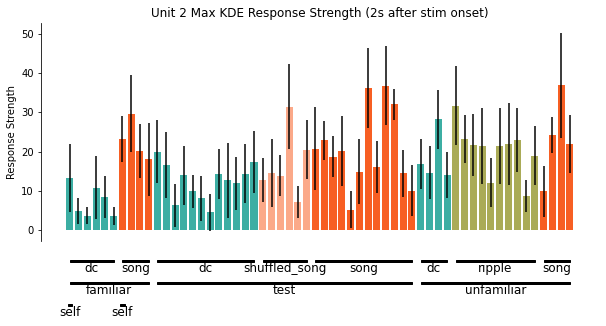

In [15]:
fig = plt.figure(figsize=(10, 4))
plot_all_stim_responses(unit1_df, mode="max_response")
plt.title("Unit 1 Max KDE Response Strength (2s after stim onset)")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(10, 4))
plot_all_stim_responses(unit2_df, mode="max_response")
plt.title("Unit 2 Max KDE Response Strength (2s after stim onset)")
plt.show()
plt.close(fig)

## IV. Slicing stims by stimulus conditions

Convenient functions slicing stimuli by condition

In [16]:
def plot_comparison(unit_df, *splits, figsize=(6, 5)):
    
    fig = plt.figure(figsize=figsize)
    
    # Plot 1: PSTH and Spike Rasters
    ax = fig.add_axes([0, 0, 1, 1])
    dfs = [split(unit_df) for split in splits]
    min_stim_duration = np.min([np.min(df["stim_duration"]) for df in dfs])
    
    kdes = [plot_kde(dfs[i], plot_errors=False, label=splits[i].__name__) for i in range(len(splits))]

    xlim = plt.xlim()
    ymax = plt.ylim()[1]
    scale_per_row = 10
    
    step_sizes = [ymax * len(df) / scale_per_row for df in dfs]
    steps = [0] + [-np.sum(step_sizes[:i]) for i in range(1, len(step_sizes) + 1)]
    
    for i in range(len(splits)):
        plot_raster(
            np.concatenate(list(dfs[i]["spike_times"])),
            yrange=(steps[i], steps[i+1]),
            ax=plt.gca(),
            color=kdes[i][0].get_color(),
        )

    plt.ylabel("Firing Rate (Hz)")
    plt.vlines(0, *plt.ylim(), linestyle="--", color="Red")
    plt.xlabel("t (seconds)")

    plt.xlim(*xlim)
    plt.legend(loc=(1, 0))
    
    # Plot 2: Max response strength metric
    rs_ax = fig.add_axes([1.2, 0.3, 0.4, 0.5])
    
    xticklabels = []
    xticks = []
    for split_idx in range(len(splits)):
        df = dfs[split_idx]
        
        _baseline_cache = {}
        
        group_rses = []
        for i in range(len(df)):
            row = df.iloc[i]
            response, se = RS.max_response(row["spike_times"], min_stim_duration, compute_std_error=True)
            group_rses.append(response)
        
        xticks.append(split_idx + 0.5)
        xticklabels.append(splits[split_idx].__name__)
        rs_ax.bar(
            split_idx + 0.5,
            np.mean(group_rses), 
            0.75, 
            yerr=2 * np.std(group_rses) / np.sqrt(len(group_rses)),
            color=kdes[split_idx][0].get_color(),
        )
    rs_ax.set_xticks(xticks)
    rs_ax.set_xticklabels(xticklabels)
    rs_ax.set_title("$RS_{maxKDE}$")
    
    # Plot 3: MEan metric
    rs_ax_mean = fig.add_axes([1.8, 0.3, 0.4, 0.5])
    
    xticklabels = []
    xticks = []
    for split_idx in range(len(splits)):
        df = dfs[split_idx]
        
        _baseline_cache = {}
        
        group_rses = []
        for i in range(len(df)):
            row = df.iloc[i]
            response, se = RS.rate(row["spike_times"], time_window=(0, row["stim_duration"]))
            group_rses.append(response)
        
        xticks.append(split_idx + 0.5)
        xticklabels.append(splits[split_idx].__name__)
        rs_ax_mean.bar(
            split_idx + 0.5,
            np.mean(group_rses), 
            0.75, 
            yerr=2 * np.std(group_rses) / np.sqrt(len(group_rses)),
            color=kdes[split_idx][0].get_color(),
        )
    rs_ax_mean.set_xticks(xticks)
    rs_ax_mean.set_xticklabels(xticklabels)
    
    rs_ax_mean.set_title("$RS_{mean}$")

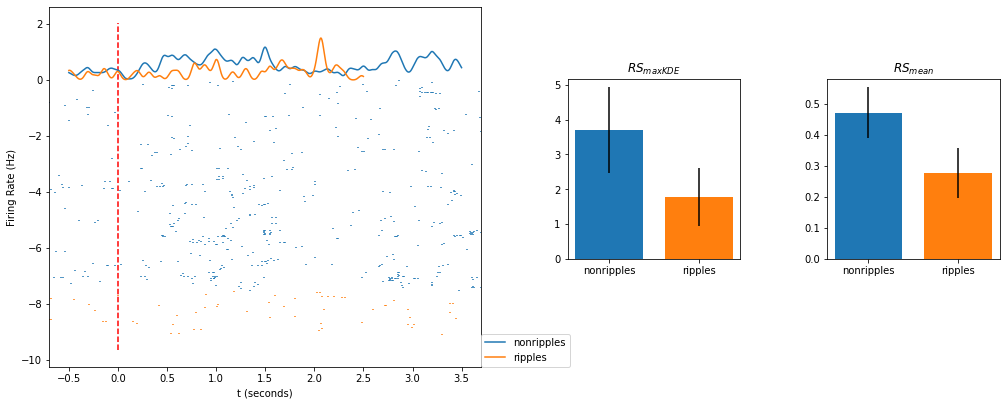

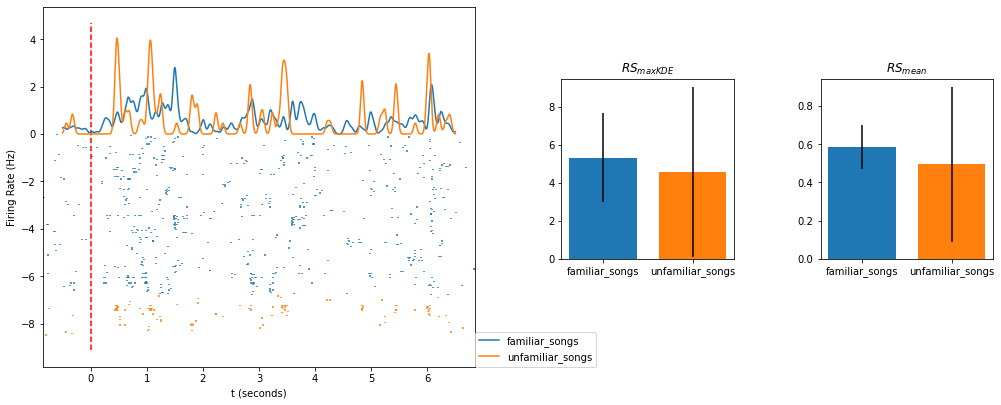

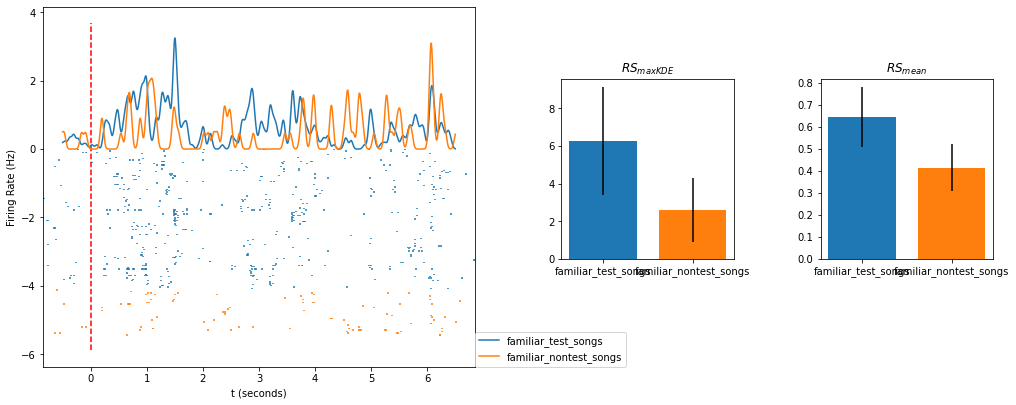

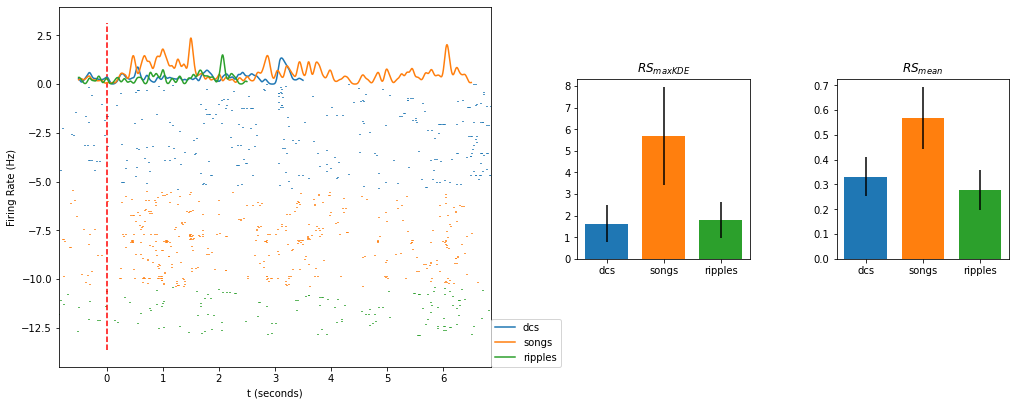

In [17]:
plot_comparison(unit1_df, groups.nonripples, groups.ripples)
plt.show()

plot_comparison(unit1_df, groups.familiar_songs, groups.unfamiliar_songs)
plt.show()

plot_comparison(unit1_df, groups.familiar_test_songs, groups.familiar_nontest_songs)
plt.show()

plot_comparison(unit1_df, groups.dcs, groups.songs, groups.ripples)
plt.show()

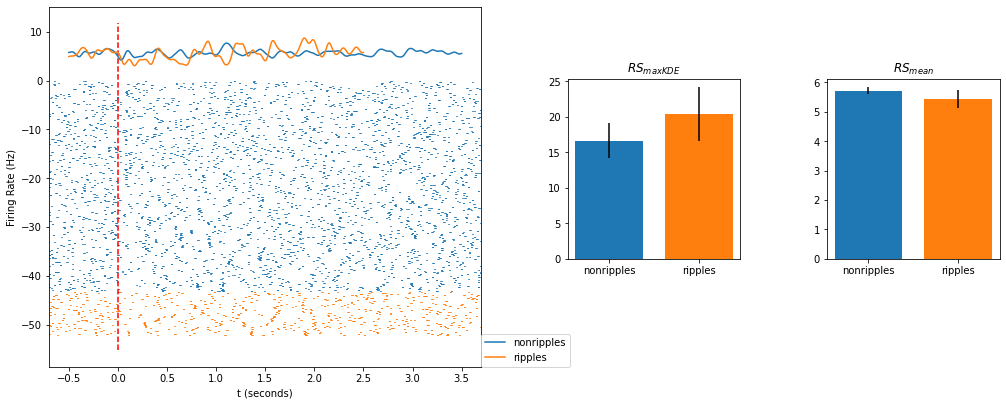

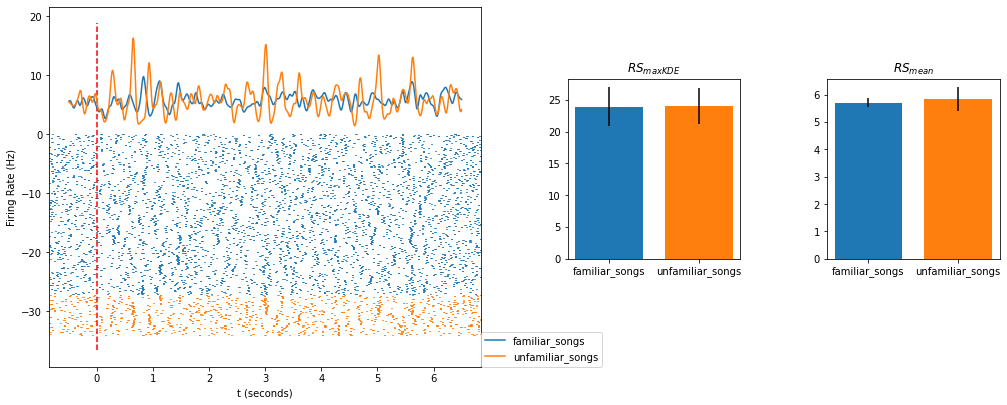

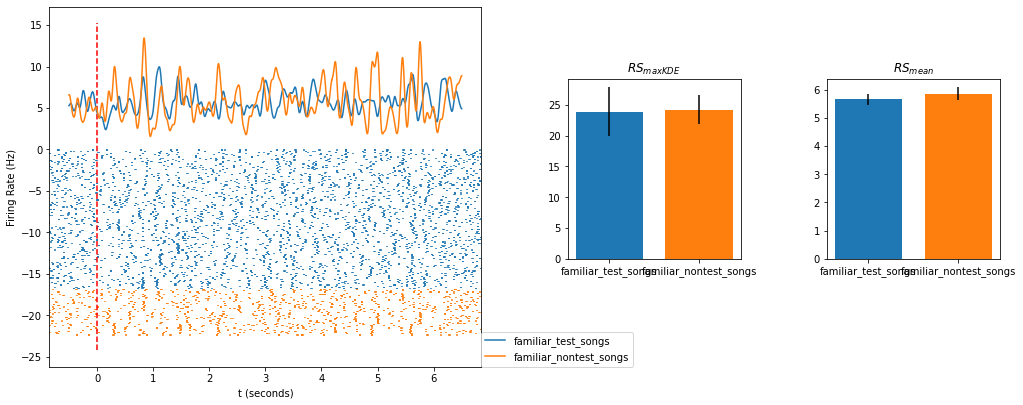

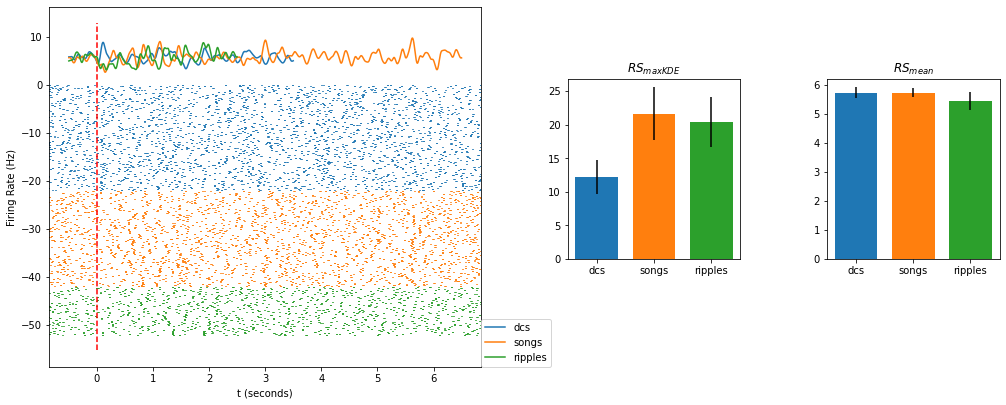

In [18]:
plot_comparison(unit2_df, groups.nonripples, groups.ripples)
plt.show()

plot_comparison(unit2_df, groups.familiar_songs, groups.unfamiliar_songs)
plt.show()

plot_comparison(unit2_df, groups.familiar_test_songs, groups.familiar_nontest_songs)
plt.show()

plot_comparison(unit2_df, groups.dcs, groups.songs, groups.ripples)
plt.show()

### I am hella sus.

In particular for unit2, why are responses to songs and ripples so much higher? The firing rates seem pretty homogoneous. Lets look into a few examples in closer detail...

In [19]:
def plot_n_example_kdes(unit_df, *splits):
    min_stim_duration = np.min(unit_df["stim_duration"])
    fig = plt.figure(figsize=(4, 4))
    axes = []
    max_ylim = 0
    for i, split in enumerate(splits):
        df = split(unit_df)
        
        ax = fig.add_axes([i, 0, 0.8, 0.8])
        for j in range(10):
            plot_kde(df.iloc[j:j+1], plot_errors=False, color="Black", alpha=0.5)
            
            t_arr, kde, _ = fit_kde(df.iloc[j]["spike_times"], (0, df.iloc[j]["stim_duration"]))
            best = np.argmax(kde[t_arr < min_stim_duration])
            
            ax.scatter([t_arr[best]], [kde[best]], marker="s", s=100)
        axes.append(ax)
        max_ylim = max(max_ylim, plt.ylim()[1])
        
    for ax in axes:
        ax.set_ylim(0, max_ylim)
        ax.set_xlim(-0.5, 3.5)
        
    plt.show()

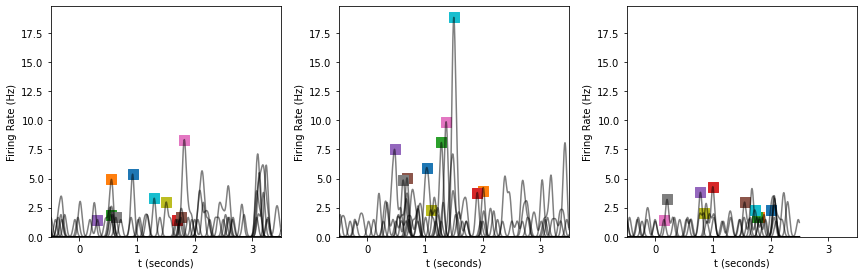

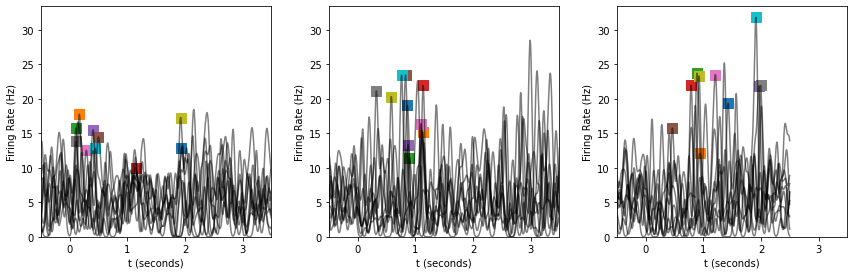

In [20]:
plot_n_example_kdes(unit1_df, groups.dcs, groups.songs, groups.ripples)
plt.show()

plot_n_example_kdes(unit2_df, groups.dcs, groups.songs, groups.ripples)
plt.show()

### Somehow, it seems legit...